# k-means

### imports

In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import euclidean

from scipy.io import loadmat

from tqdm import trange
from typing import Tuple

from sklearn.metrics import silhouette_score, calinski_harabaz_score
from scipy.spatial.distance import mahalanobis

from collections import defaultdict


%matplotlib inline

### data preparation

In [2]:
faces_path = './facesYale.mat'
faces = loadmat(faces_path)

person_train = faces['personTrain']
faces_train = faces['facesTrain']
features_train = faces['featuresTrain']


person_test = faces['personTest']
faces_test = faces['facesTest']
features_test = faces['featuresTest']

features_all = np.concatenate([features_train, features_test])
faces_all = np.concatenate([faces_train, faces_test], axis=-1)

### helper functions

In [3]:
def plot_image(img: np.ndarray,
               figsize: Tuple[int, int] = (6, 6),
               title: str = None,
               axis=None) -> None:

    if axis is not None:
        ax = axis
    else:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)

    if title is not None:
        ax.set_title(title)
    ax.imshow(img, interpolation='hamming', cmap='gray')
    if axis is None:
        plt.show()
        
def split_by_cluster(faces, clusters):
    return {int(cluster): faces[..., clusters == cluster] for cluster in np.unique(clusters)}

def concat_faces(faces, row_len=8):
    height = int(np.ceil(faces.shape[-1] / row_len))
    faces_height, faces_width = faces.shape[:-1]
    gallery = np.zeros((faces_height * height, faces_width * row_len))
    for idy in range(height):
        for idx in range(row_len):
            offset_y = idy * faces_height
            offset_x = idx * faces_width
            idface = idy * row_len  + idx
            if idface < faces.shape[-1]:
                gallery[
                    offset_y : offset_y + faces_height,
                    offset_x : offset_x + faces_width
                ] = faces[..., idface]
    return gallery

def get_mahalanobis_distance(points):
    inv_cov = np.linalg.inv(np.cov(points.T))
    def distance(x, y):
        return mahalanobis(x, y, inv_cov)
    return distance

### k-means and k-means++ implementation

In [4]:
class KMeans:
    def __init__(self, points, distance=euclidean, n_of_clusters=3, max_iter=300, epsilon=0.0001):
        self.points = points
        self.distance = distance
        self.n_of_clusters = n_of_clusters
        self.centroids = None
        self.clusters = None
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.iterations = None            
        
    def initialize(self):
        self.started = False
        self.iterations = 0
        self.centroids = np.array(
            self.points[np.random.choice(np.arange(len(self.points)), self.n_of_clusters)]
        )
        self.clusters = np.zeros(len(self.points))               
    
    def _find(self):
        for idx, point in enumerate(self.points):
            distances = [self.distance(point, centroid) for centroid in self.centroids]
            self.clusters[idx] = np.argmin(distances)
            
    
    def _move(self):
        self._prev_centroids = np.array(self.centroids)
        for clust in range(self.n_of_clusters):
            clustered = self.points[self.clusters == np.array(clust)]
            if len(clustered) > 0:
                self.centroids[clust] = np.mean(clustered, axis=0)                
  
    def clusterize(self):
        self.initialize()
        
        while not self._is_converged():
            self.started = True
            self._find()
            self._move()
            self.iterations += 1            
            
    def _is_converged(self):
        if not self.started:
            return False
        prev = np.array(self._prev_centroids)
        curr = np.array(self.centroids)
        diff = curr - prev
        length = np.sqrt(np.square(diff).sum())
        return length <= self.epsilon
        

class KMeansPlus(KMeans):
    def initialize(self):
        self.iterations = 0
        self.started = False
        self.centroids = self.points[np.random.choice(np.arange(len(self.points)))].reshape(1, -1)
        for _ in range(self.n_of_clusters - 1):
            new_centroid = self._get_new_centroid()
            self.centroids = np.vstack([self.centroids, new_centroid.reshape(1, -1)])
        self.clusters = np.zeros(len(self.points))
    
    def _get_new_centroid(self):
        distances = []
        for point in self.points:
            distances.append(np.min([self.distance(point, centr) for centr in self.centroids]))
        distances = np.array(distances)
        distances /= distances.sum()
        return self.points[np.random.choice(np.arange(len(self.points)), p=distances)]

### experiment settings

In [5]:
mahal_dist = get_mahalanobis_distance(features_all)

algorithms = {
    'kmeans': KMeans,
    'kmeans++': KMeansPlus
}
distances = {
    'euclidean': euclidean,
    'mahalanobis': mahal_dist
}

### running clustering

In [6]:
results_iterations = []
results_silhouette = []
results_calinski = []
results_clusters = {}

for k in [2, 5, 8, 10]:
    for algorithm_name, algorithm in algorithms.items():
        for distance_name, distance in distances.items():
            silhs = defaultdict(list)
            calis = []
            iters = []
            for _ in range(10):
                clusterer = algorithm(points=features_all, n_of_clusters=k, distance=distance)
                clusterer.clusterize()
                for dist_name, distance in distances.items():
                    silhs[dist_name].append(silhouette_score(
                        clusterer.points,
                        clusterer.clusters,
                        metric=distance
                    ))

                calinski = calinski_harabaz_score(clusterer.points, clusterer.clusters)
                iterations = clusterer.iterations
                calis.append(calinski)
                iters.append(iterations)
            results_clusters[(k, algorithm_name, distance_name)] = clusterer.clusters
            results_iterations.append({
                'k': k,
                'algorithm': algorithm_name,
                'distance': distance_name,
                'mean_iterations': np.mean(iters)
            })
            results_calinski.append({
                'k': k,
                'algorithm': algorithm_name,
                'distance': distance_name,
                'score': np.mean(calis)
            })
            results_silhouette.append({
                'k': k,
                'algorithm': algorithm_name,
                'distance': distance_name,
                **{
                    k+'_silhouette': np.mean(v) for k, v in silhs.items()
                }
            })
            
            

### discussion

There are few of analysing results of clustering algorithm. If our data is explicitly labeled we can check if labels in clusters are homogenous. In our experiment we don't have labels, so we need to use other options. There are ways of checking if our clusters are well defined. Two of them are implemented in `scikit-learn` and we will rely on them. In both metric the higher the score, the better the clusters.

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index

All algorithms were repeated 10 times, scores are averaged over all run. It is due to the fact, that models with randomized start conditions (and k-means as one of them) can give different results over many runs.

In [7]:
pd.DataFrame(results_calinski)

algorithm     distance   k      score
0     kmeans    euclidean   2  17.033628
1     kmeans  mahalanobis   2  15.402022
2   kmeans++    euclidean   2  16.099405
3   kmeans++  mahalanobis   2  11.209452
4     kmeans    euclidean   5  17.155935
5     kmeans  mahalanobis   5  18.272181
6   kmeans++    euclidean   5  20.121210
7   kmeans++  mahalanobis   5  15.813793
8     kmeans    euclidean   8  24.516289
9     kmeans  mahalanobis   8  21.199427
10  kmeans++    euclidean   8  24.367606
11  kmeans++  mahalanobis   8  18.722799
12    kmeans    euclidean  10  25.074375
13    kmeans  mahalanobis  10  23.183625
14  kmeans++    euclidean  10  28.993000
15  kmeans++  mahalanobis  10  23.794102

As we can see on the results above the biggest score is achieved with $k=10$. Euclidean distance is slightly better over most of the runs, while it is much better in basic k-means with two clusters. It may not be a good idea to rely on that metric when comparing between distances because it may calculated score in "euclidean-like" way.

In [8]:
pd.DataFrame(results_silhouette)

algorithm     distance  euclidean_silhouette   k  mahalanobis_silhouette
0     kmeans    euclidean              0.151802   2                0.118965
1     kmeans  mahalanobis              0.168963   2                0.134748
2   kmeans++    euclidean              0.164563   2                0.133089
3   kmeans++  mahalanobis              0.131133   2                0.125014
4     kmeans    euclidean              0.113619   5                0.157031
5     kmeans  mahalanobis              0.124917   5                0.170931
6   kmeans++    euclidean              0.146698   5                0.167042
7   kmeans++  mahalanobis              0.110153   5                0.161774
8     kmeans    euclidean              0.202622   8                0.234240
9     kmeans  mahalanobis              0.182320   8                0.233914
10  kmeans++    euclidean              0.200540   8                0.241560
11  kmeans++  mahalanobis              0.170987   8                0.230786
12    kmeans    euclidean              0.217352  10                0.256444
13    kmeans  mahalanobis              0.217607  10                0.268122
14  kmeans++    euclidean              0.255036  10                0.277806
15  kmeans++  mahalanobis              0.219889  10                0.286275

In silhouette score we can deal with the problem of calculating metric score with euclidean or mahalanobis distance. We can see the pattern that if we use the euclidean distance in training algorithm then euclidean silhouette score is higher than mahalanobis silhouette score and vice-versa. That metrics also maximized in `k=10` despite other options.

In [9]:
pd.DataFrame(results_iterations)

algorithm     distance   k  mean_iterations
0     kmeans    euclidean   2              5.9
1     kmeans  mahalanobis   2              5.5
2   kmeans++    euclidean   2              5.8
3   kmeans++  mahalanobis   2              5.4
4     kmeans    euclidean   5              6.3
5     kmeans  mahalanobis   5              6.7
6   kmeans++    euclidean   5              6.4
7   kmeans++  mahalanobis   5              7.7
8     kmeans    euclidean   8              6.2
9     kmeans  mahalanobis   8              7.9
10  kmeans++    euclidean   8              6.3
11  kmeans++  mahalanobis   8              6.7
12    kmeans    euclidean  10              6.6
13    kmeans  mahalanobis  10              7.1
14  kmeans++    euclidean  10              6.7
15  kmeans++  mahalanobis  10              7.5

Above results show that `kmeans++` converges with the same or slightly lesser amount of iterations than basic `kmeans`. The dataset and prepared features are too simple to show the superiority of `kmeans++`.

### showing results of clustering

We can simply show each clusters of faces to check if our implementation is working correctly. These are the results of basic `kmeans` with `k=10` with euclidean/mahalanobis distance. It is hard to conclude which distance is better because there are too many things to compare.

Cluster 0


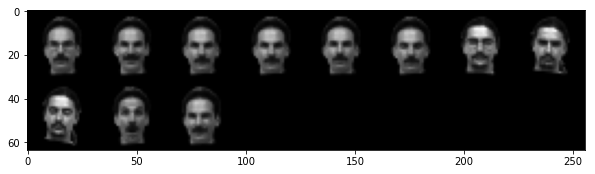

Cluster 1


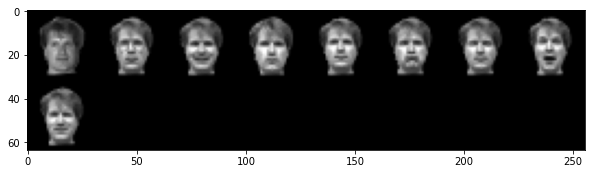

Cluster 2


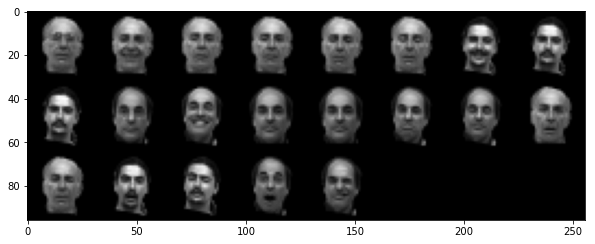

Cluster 3


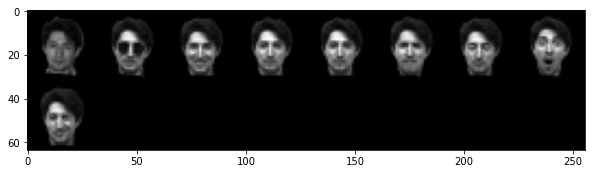

Cluster 4


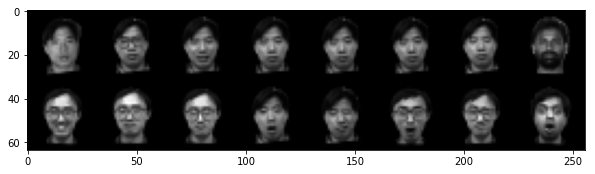

Cluster 5


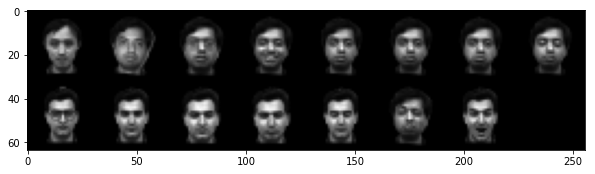

Cluster 6


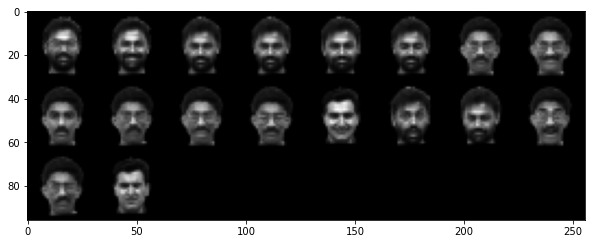

Cluster 7


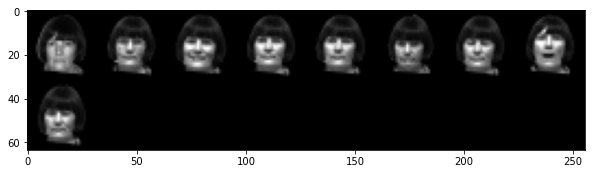

Cluster 8


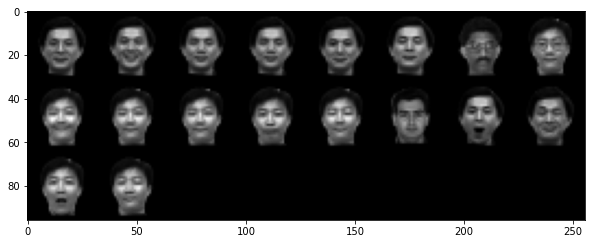

Cluster 9


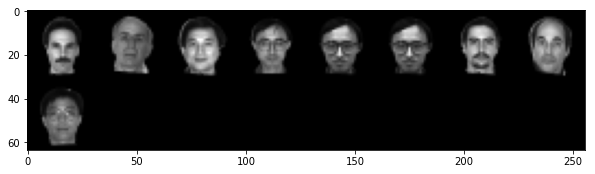

In [10]:
for cluster, faces in split_by_cluster(faces_all, results_clusters[(10, 'kmeans', 'euclidean')]).items():
    print(f'Cluster {cluster}')
    plot_image(concat_faces(faces), figsize=(10, 20))

Cluster 0


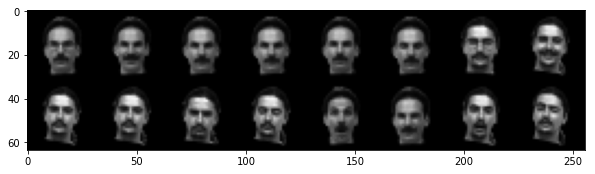

Cluster 1


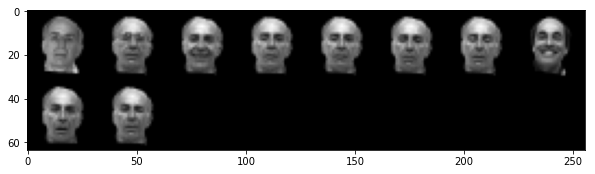

Cluster 2


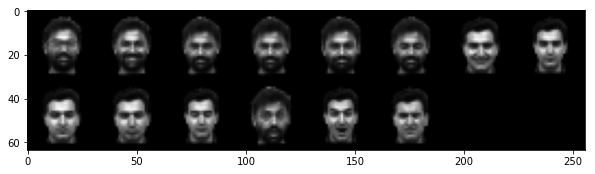

Cluster 3


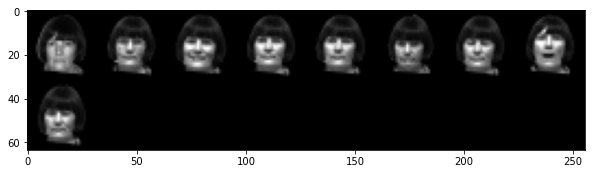

Cluster 4


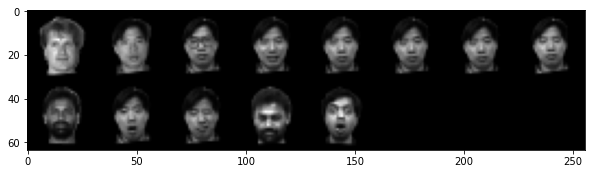

Cluster 5


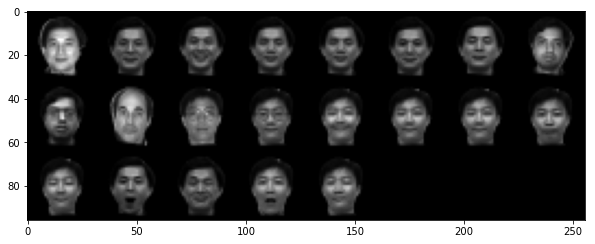

Cluster 6


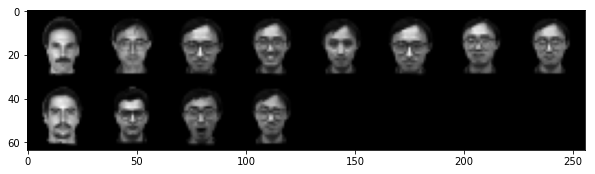

Cluster 7


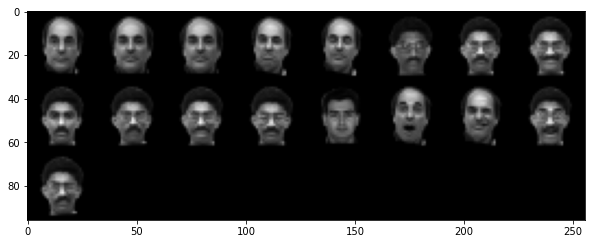

Cluster 8


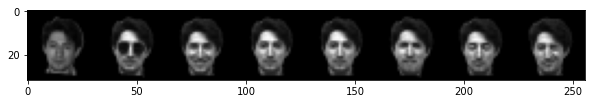

Cluster 9


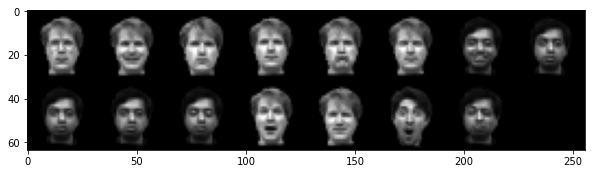

In [11]:
for cluster, faces in split_by_cluster(faces_all, results_clusters[(10, 'kmeans', 'mahalanobis')]).items():
    print(f'Cluster {cluster}')
    plot_image(concat_faces(faces), figsize=(10, 20))

We can see that both distance produced reasonable clusters.

# hierarchical clustering

### imports

In [12]:
import networkx
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette, fcluster
from networkx.algorithms.community.centrality import girvan_newman
from pprint import pprint

### preparing datasets

The analysis and results will be shown only over `dolphins` dataset for clarity, conclusion are mostly the same over all datasets.

In [13]:
dolphins = networkx.read_gml('./dolphins/dolphins.gml')
# karate = networkx.read_gml('./karate/karate.gml')
# football = networkx.read_gml('./football/football.gml')

In [14]:
datasets = {
    'dolphins': dolphins,
#     'karate': karate,
#     'football': football
}


### helper functions

In [15]:
def commute_time_distance(S):
    L = networkx.laplacian_matrix(S)
    n = L.shape[0]
    
    Linv = np.linalg.pinv(L + np.ones(L.shape)/n) - np.ones(L.shape)/n

    Linv_diag = np.diag(Linv).reshape((n, 1))
    Rexact = Linv_diag * np.ones((1, n)) + np.ones((n, 1)) * Linv_diag.T - 2 * Linv
    
    return Rexact

### running analysis

/home/unj/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/__main__.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


{'dataset': 'dolphins', 'distance': 'adjacency', 'linkage': 'single'}


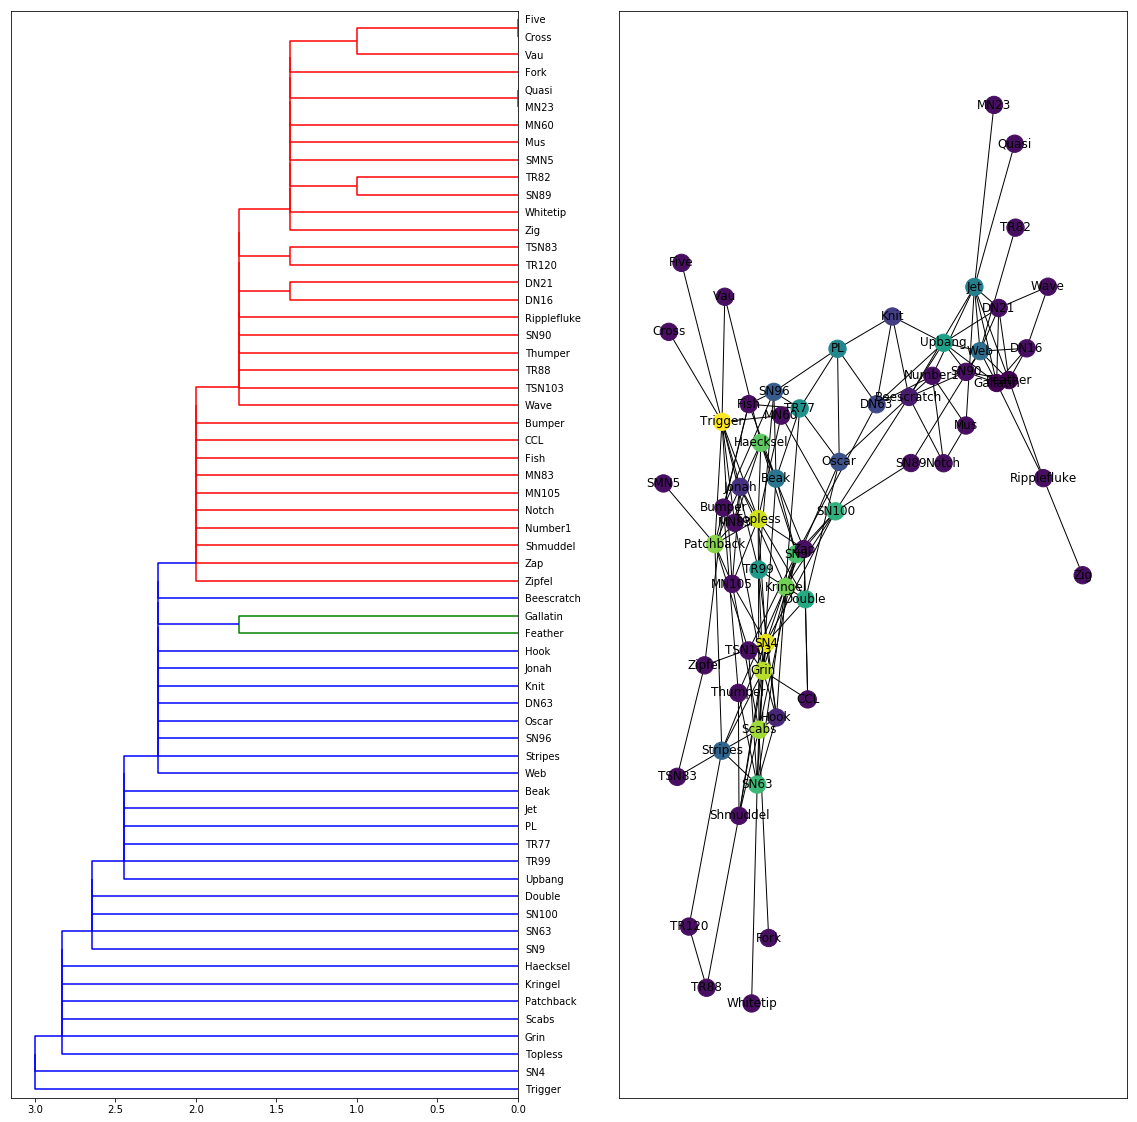

{'dataset': 'dolphins', 'distance': 'adjacency', 'linkage': 'complete'}


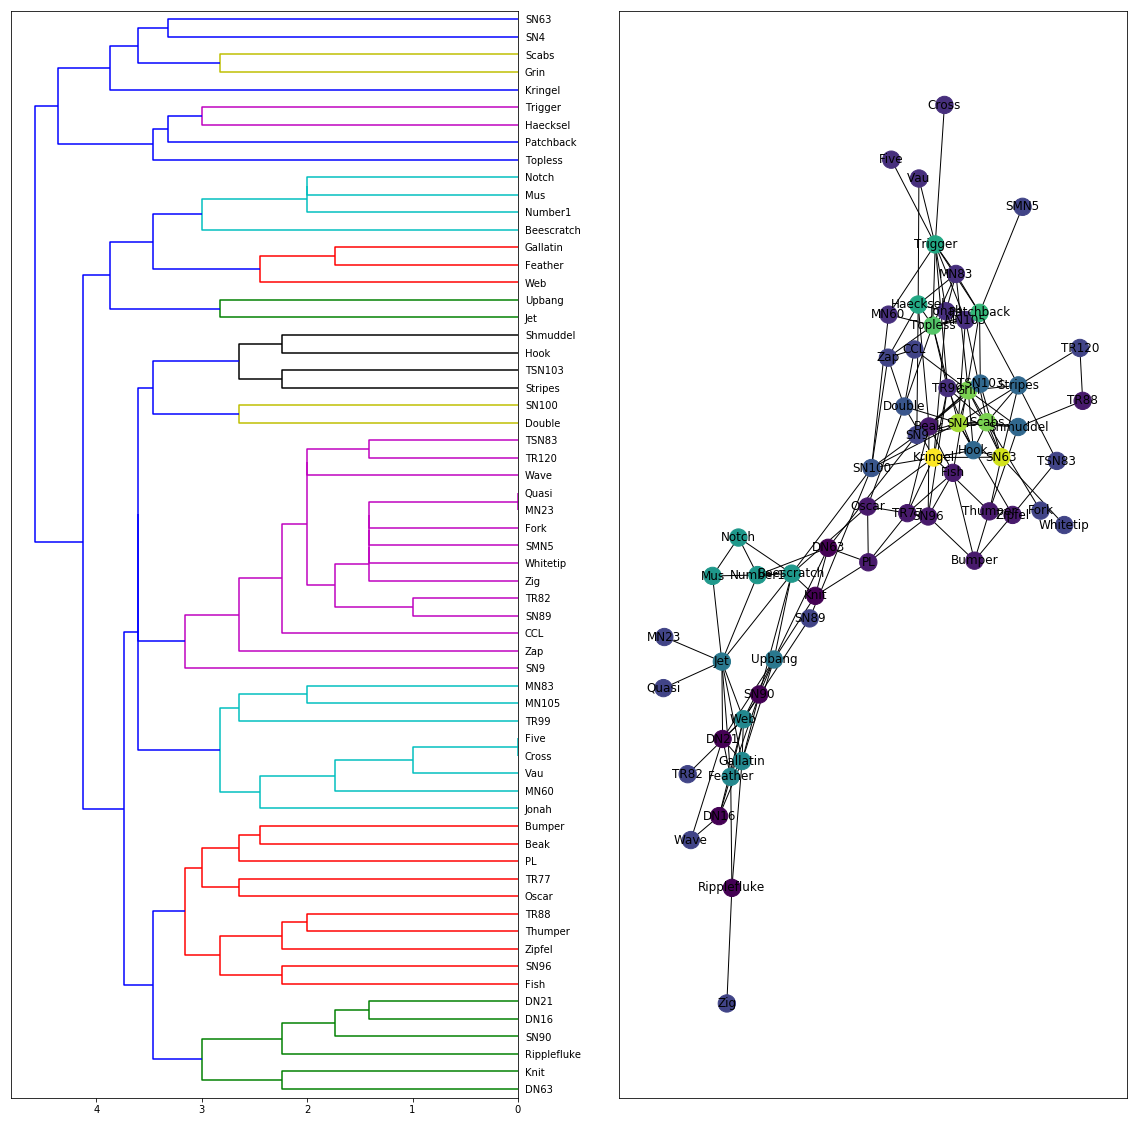

{'dataset': 'dolphins', 'distance': 'adjacency', 'linkage': 'average'}


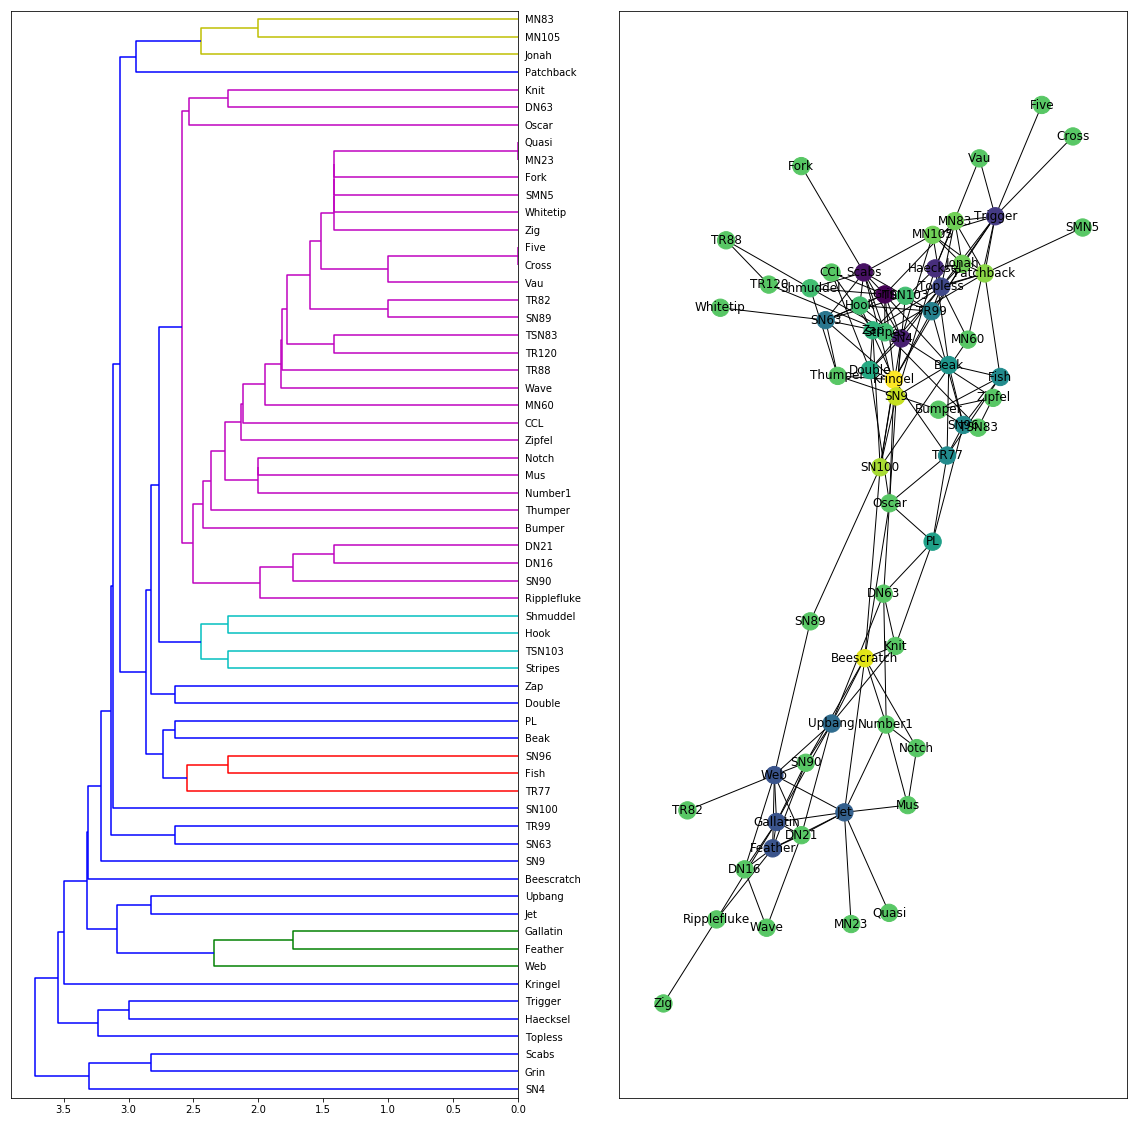

{'dataset': 'dolphins', 'distance': 'covariance', 'linkage': 'single'}


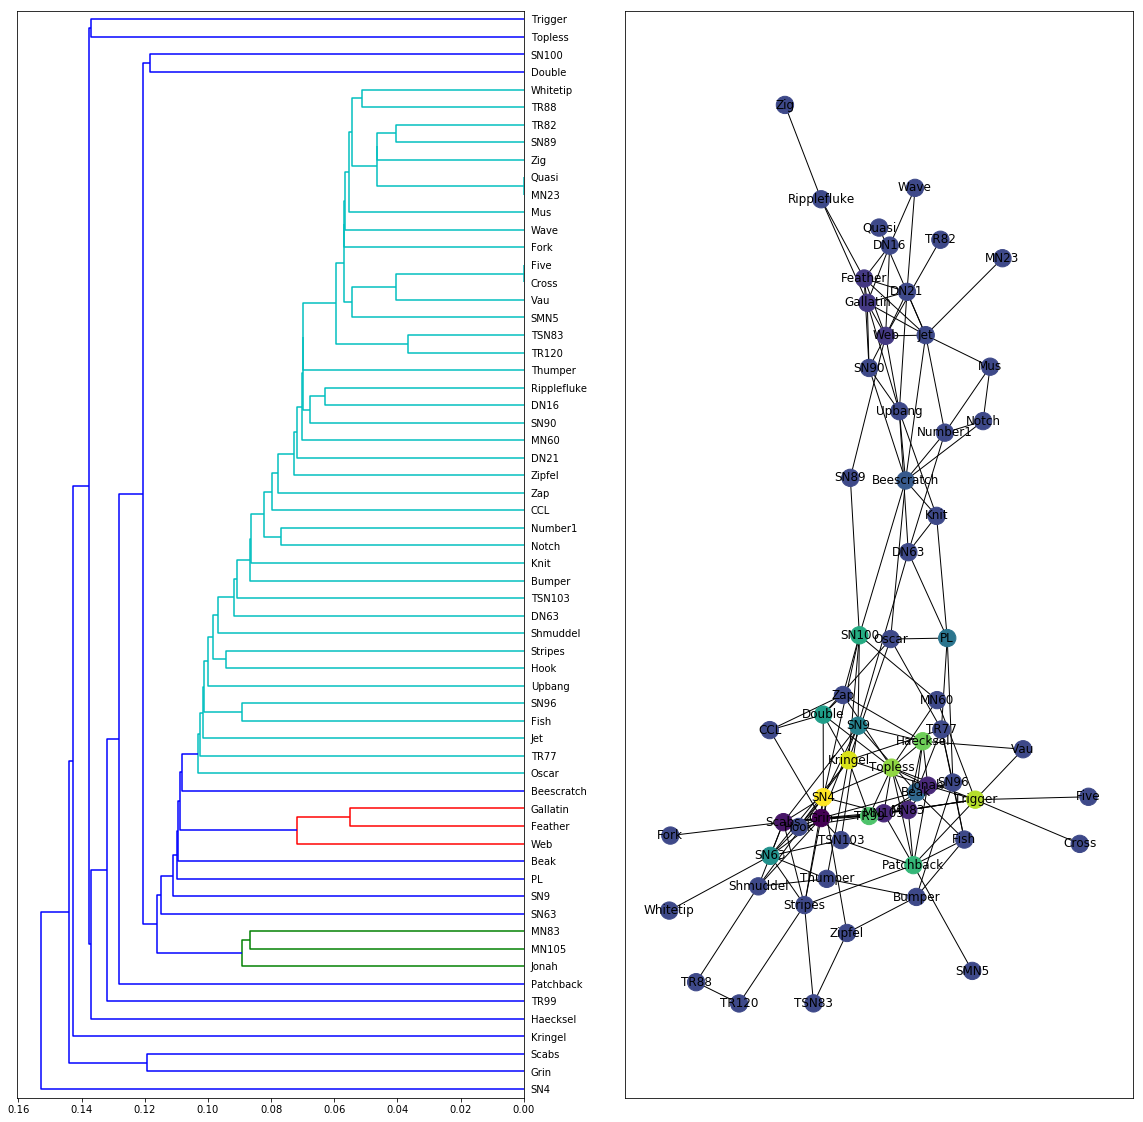

{'dataset': 'dolphins', 'distance': 'covariance', 'linkage': 'complete'}


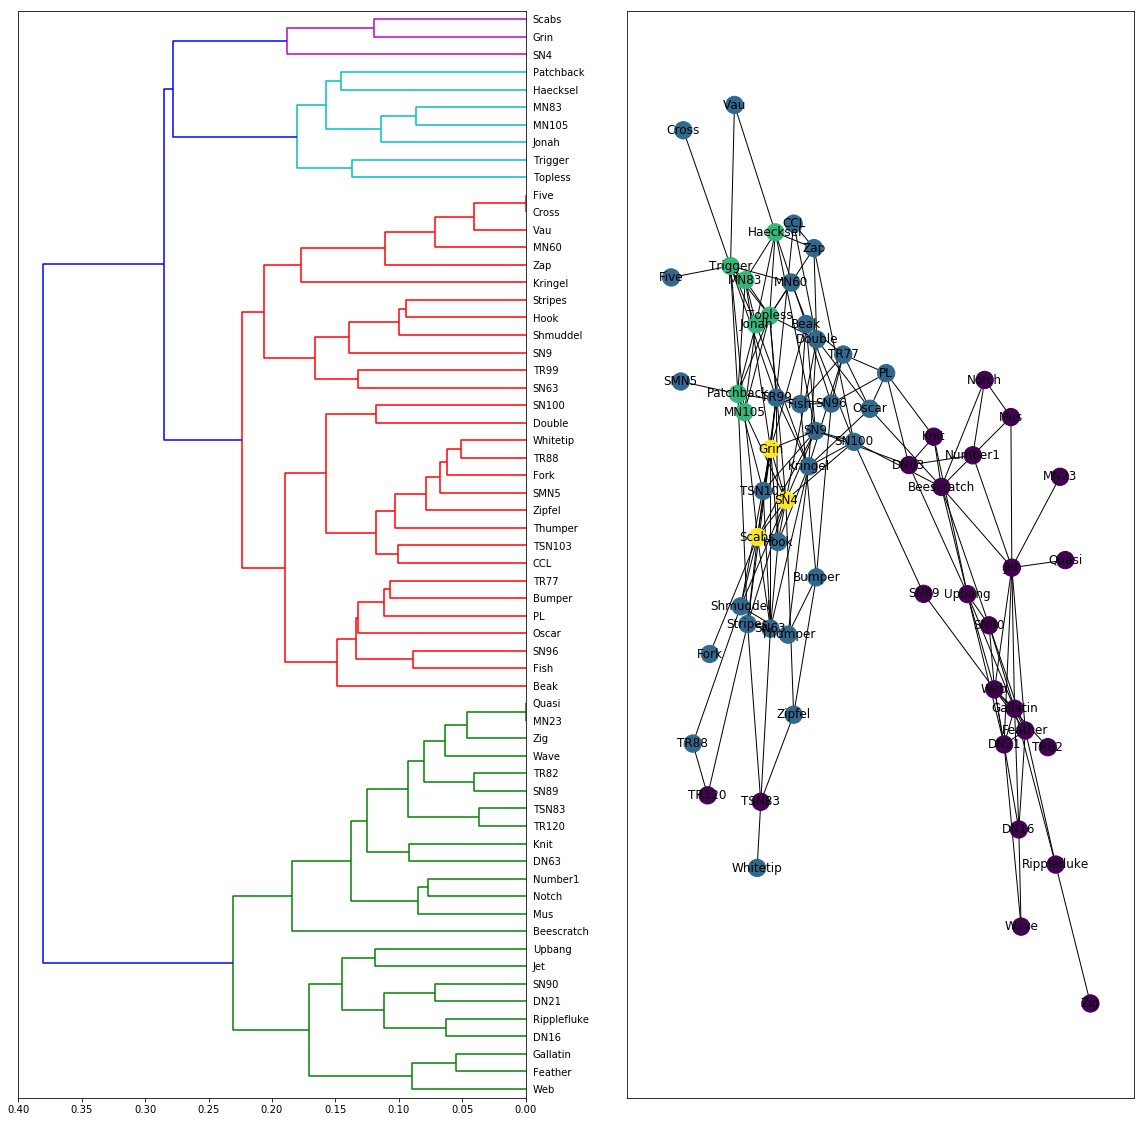

{'dataset': 'dolphins', 'distance': 'covariance', 'linkage': 'average'}


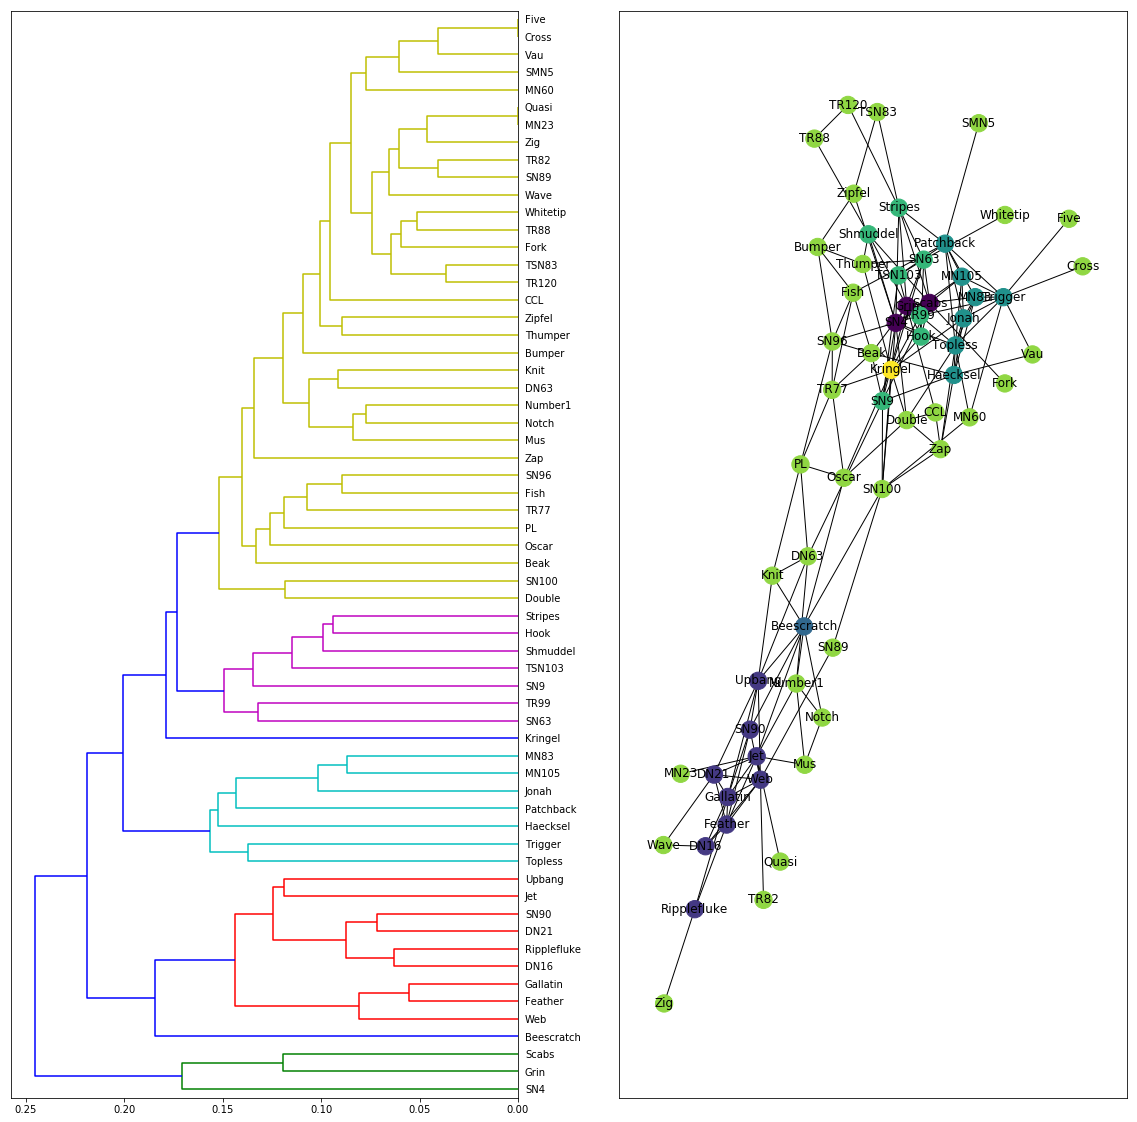

{'dataset': 'dolphins', 'distance': 'shortest_time', 'linkage': 'single'}


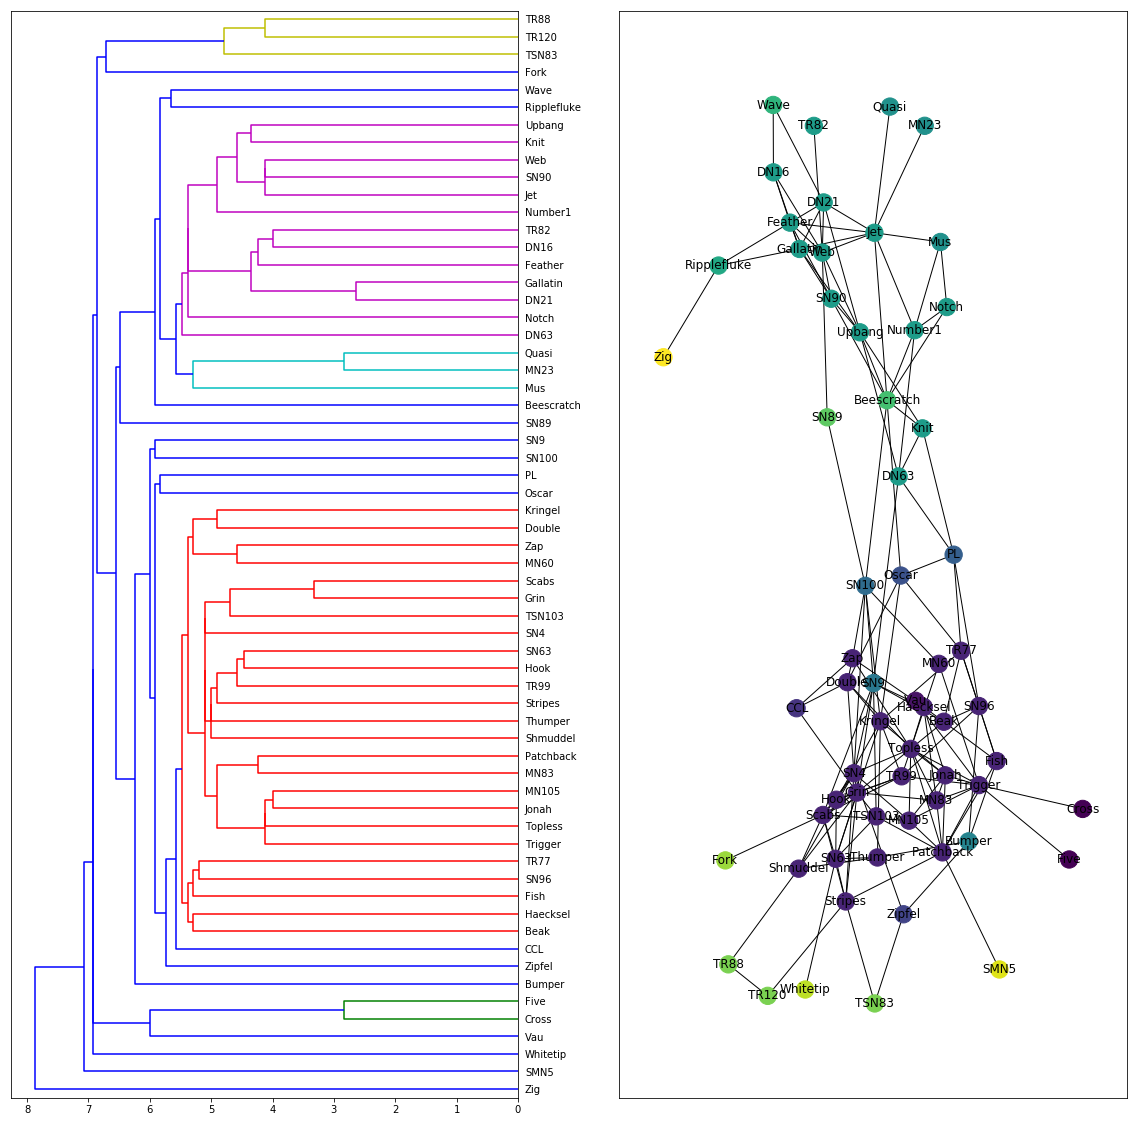

{'dataset': 'dolphins', 'distance': 'shortest_time', 'linkage': 'complete'}


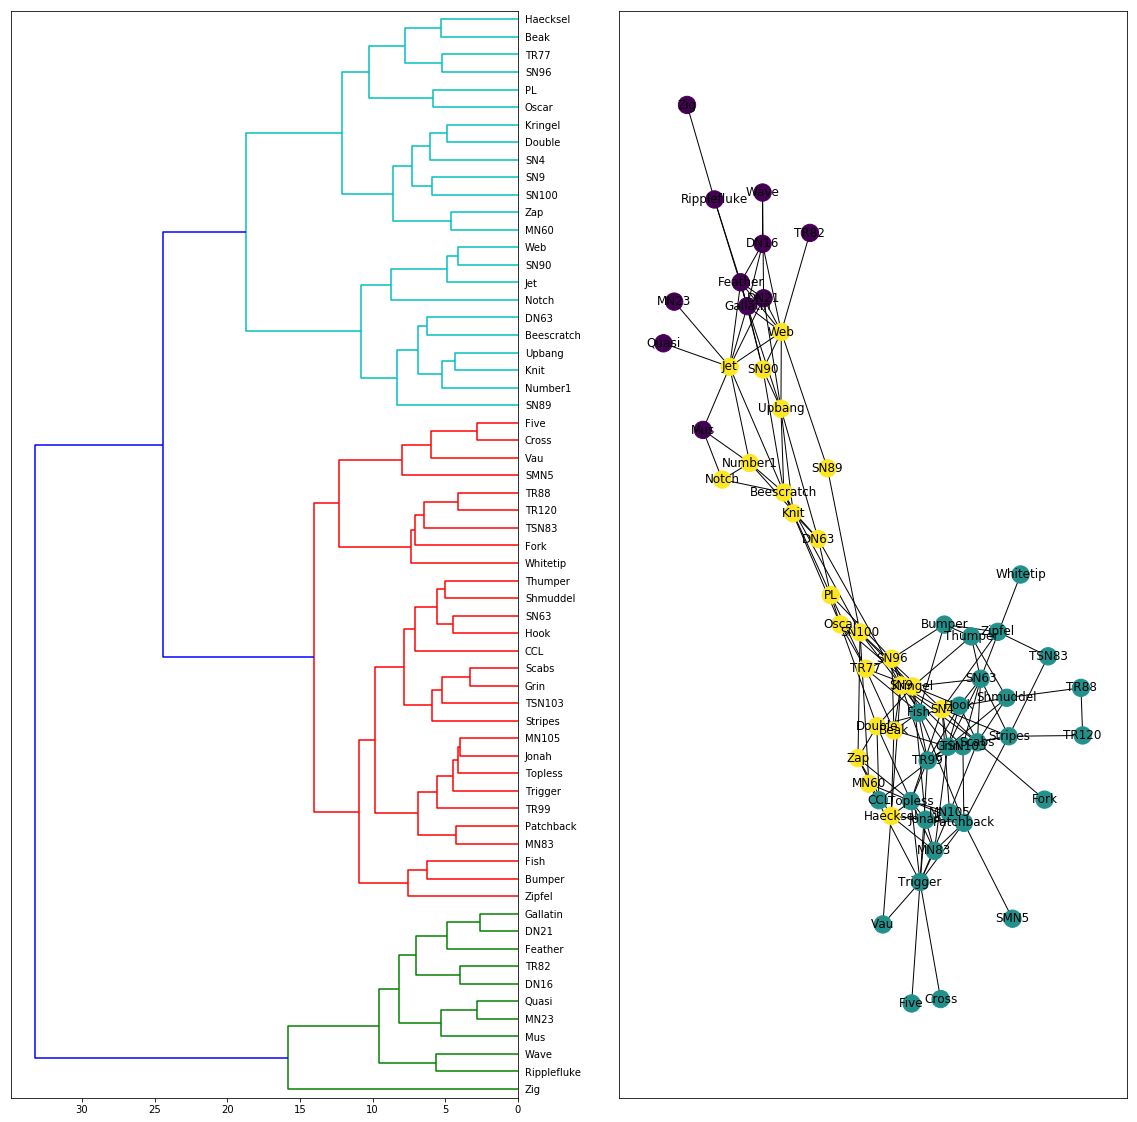

{'dataset': 'dolphins', 'distance': 'shortest_time', 'linkage': 'average'}


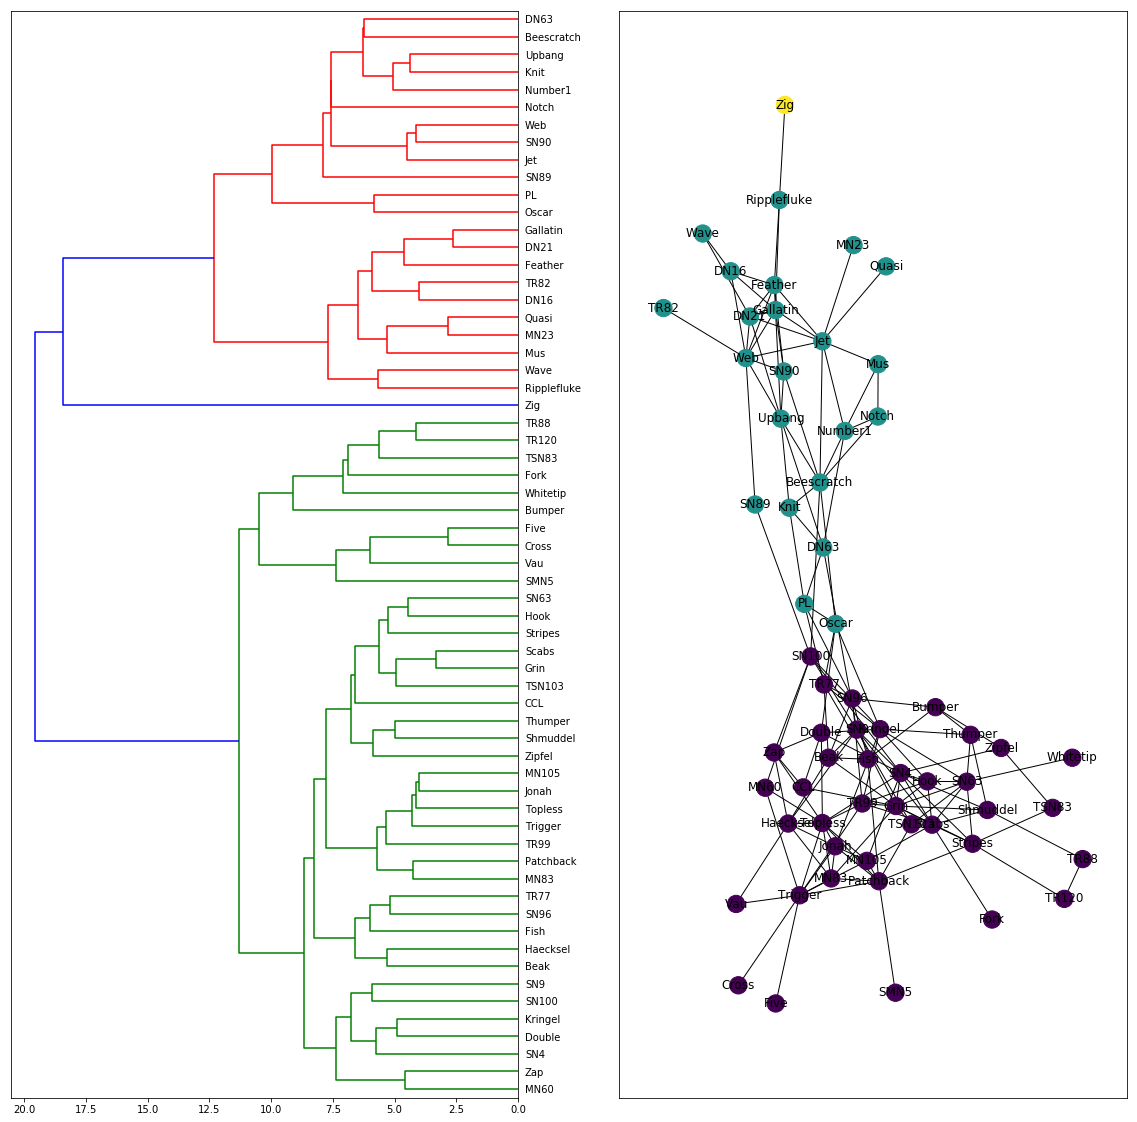

{'dataset': 'dolphins', 'distance': 'commute_time', 'linkage': 'single'}


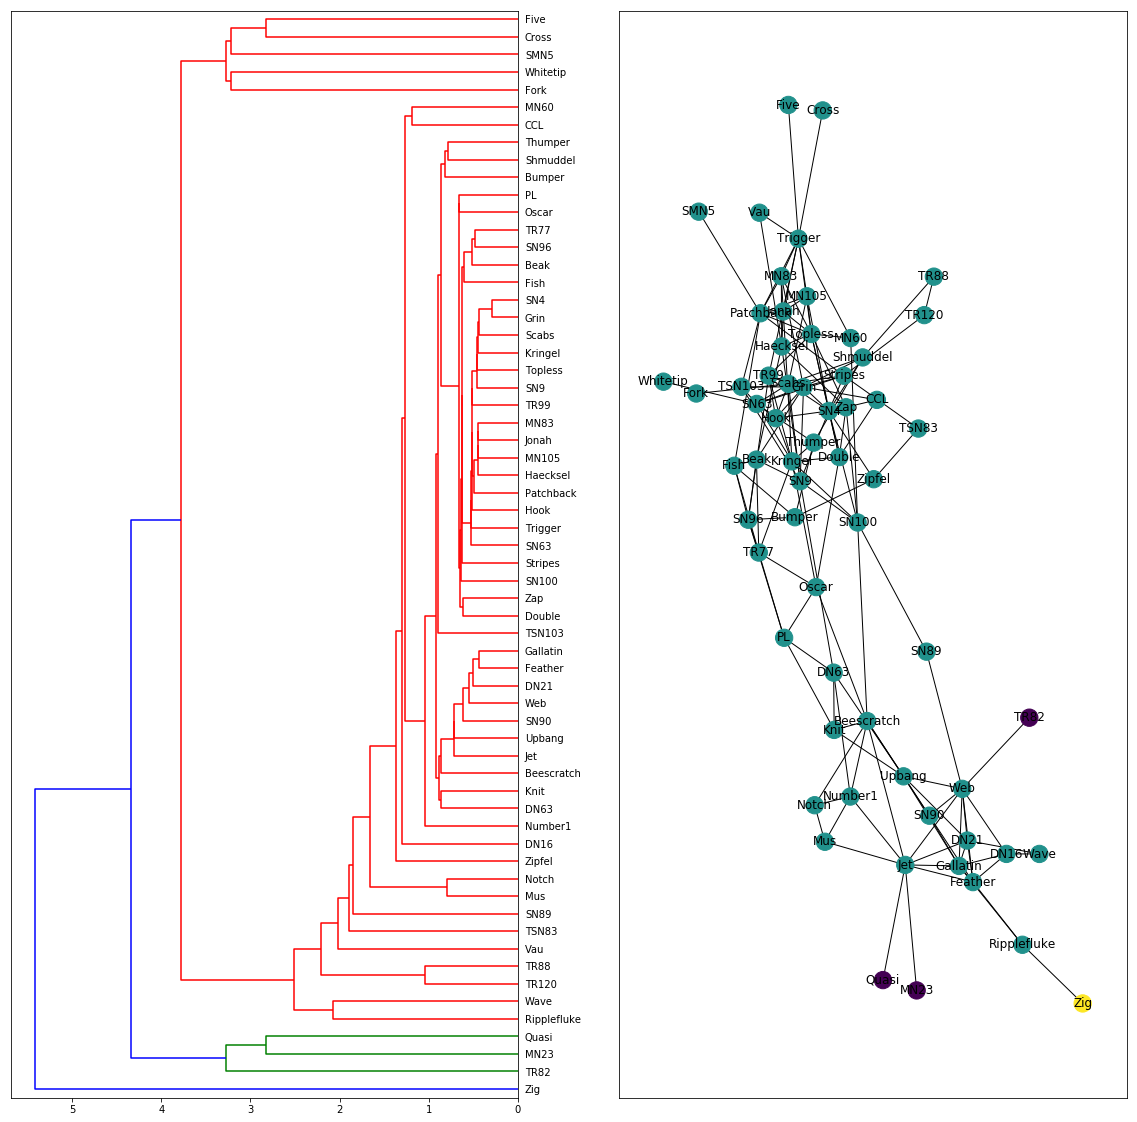

{'dataset': 'dolphins', 'distance': 'commute_time', 'linkage': 'complete'}


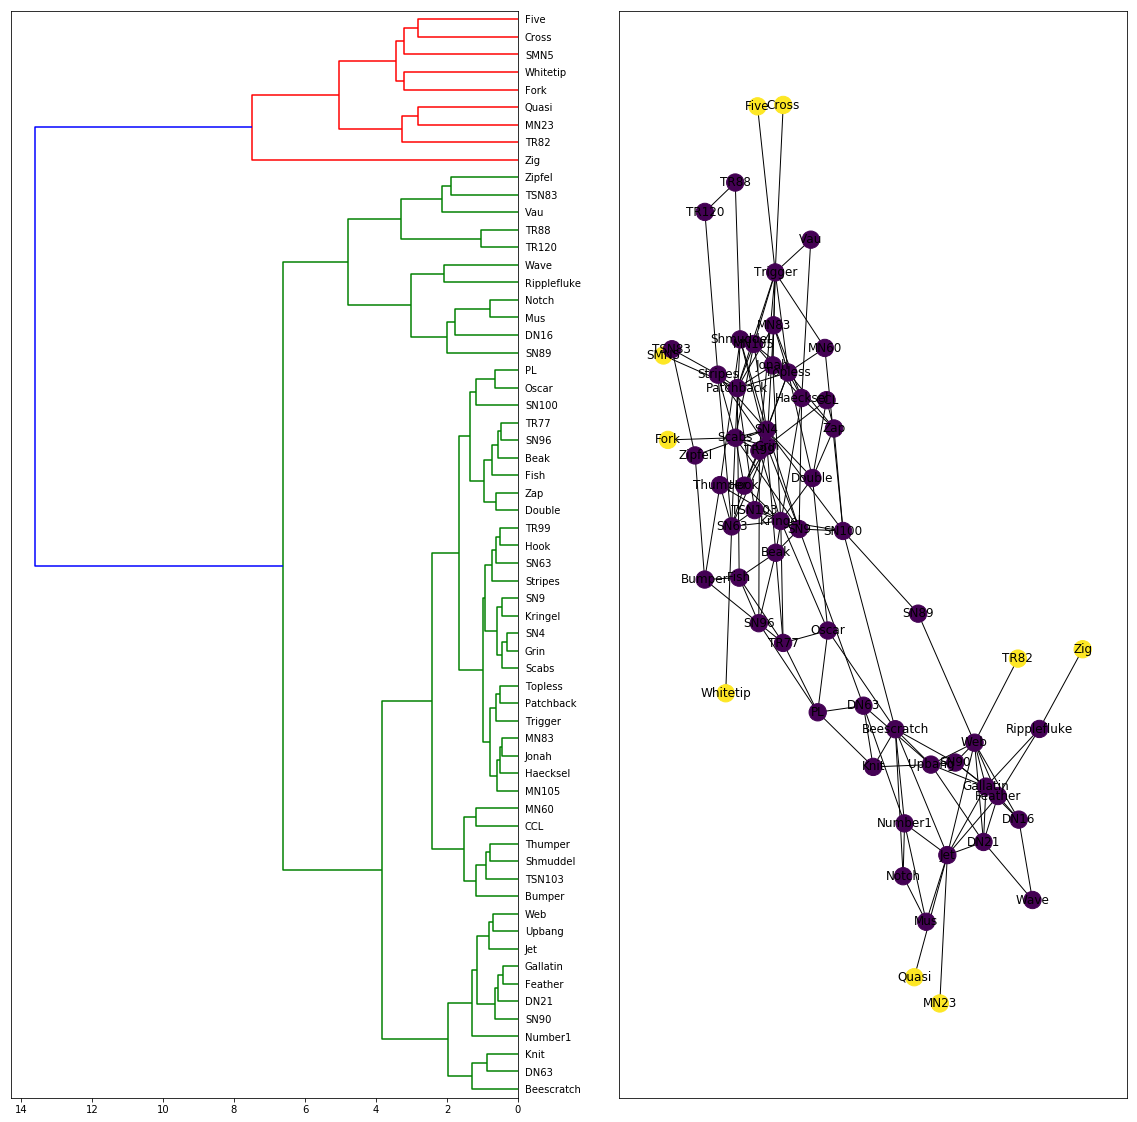

{'dataset': 'dolphins', 'distance': 'commute_time', 'linkage': 'average'}


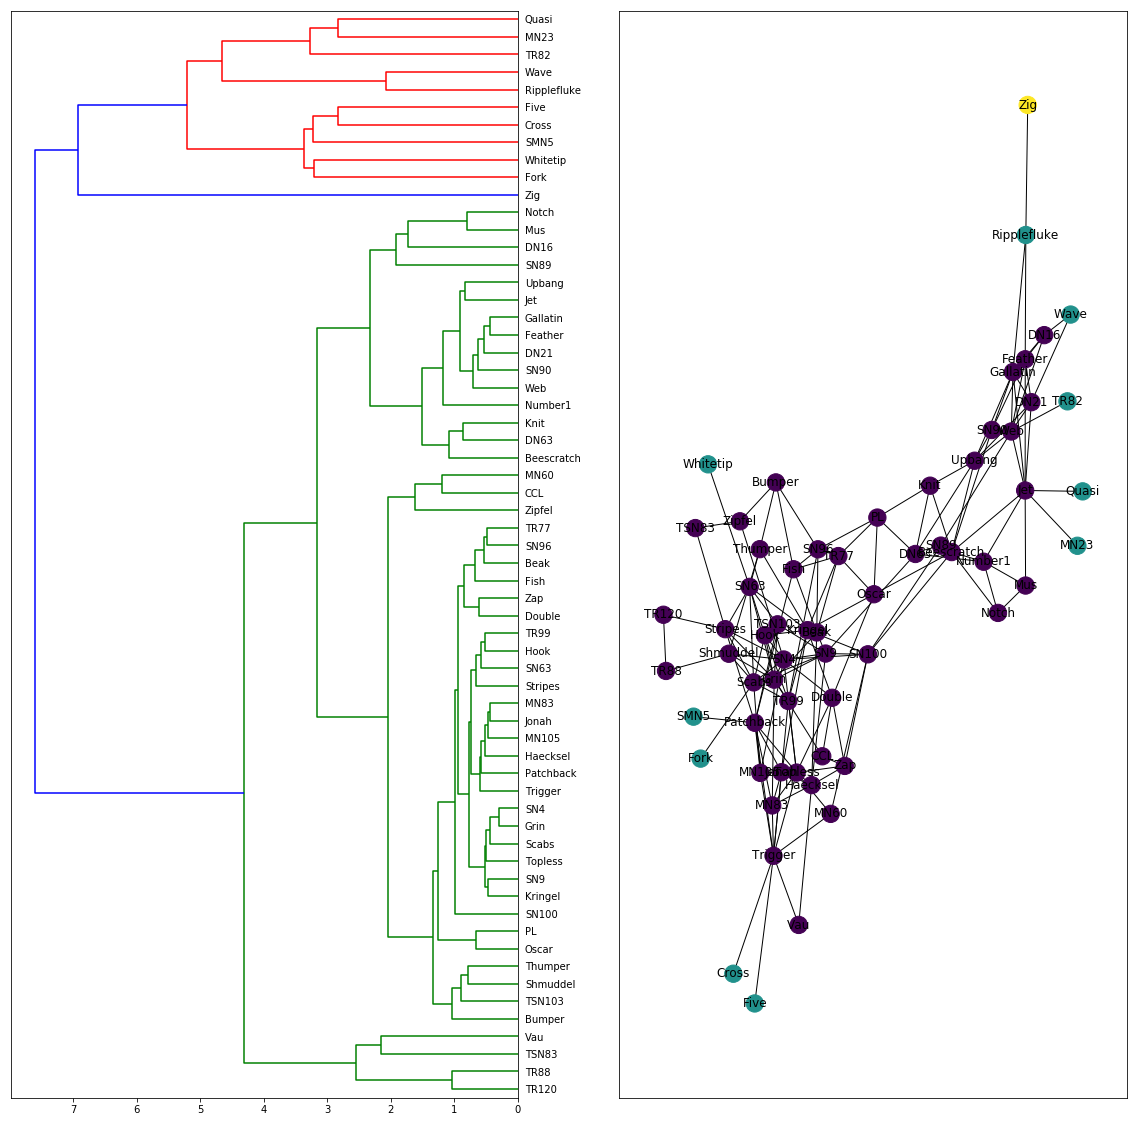

In [16]:
for dataset_name, dataset in datasets.items():    
    adj_matrix = networkx.adj_matrix(dataset).toarray()
    cov_adj_matrix = np.cov(adj_matrix)

    shortest_lengths = dict(networkx.shortest_paths.all_pairs_shortest_path_length(dataset))
    nodes = dataset.nodes()
    shortest_matrix = np.zeros((len(nodes), len(nodes)))

    for idx, row in enumerate(nodes):
        for idy, col in enumerate(nodes):
            shortest_matrix[idx, idy] = shortest_lengths[row][col]



    commute = commute_time_distance(dataset)
    matrices = {
        'adjacency': adj_matrix,
        'covariance': cov_adj_matrix,
        'shortest_time': shortest_matrix,
        'commute_time': commute
    }
    for y_name, y in matrices.items():
        for method in ['single', 'complete', 'average']:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
            link = linkage(y=y, method=method)
            pprint({
                'dataset': dataset_name,
                'distance': y_name,
                'linkage': method
            })
            _ = dendrogram(
                link, orientation='left', labels=list(dataset.nodes()), ax=ax1, leaf_font_size=10
            )
            thresh = link[:,2].max() * 0.7
            ax2.set_xticks([])
            ax2.set_yticks([])
            clusts = fcluster(link.astype(np.float), thresh, criterion='distance')
            networkx.draw_networkx(dolphins, node_color=clusts, ax=ax2)
            plt.show()

In charts on the right side there are clusters produced by dendrogram which is cut in $0.7$ of the maximum distance. We can see that dendrograms with the `average` linkage are somehow visually averaged version of `complete` and `single` linkage. Complete linkage provides much 

### community detection

We will show few first results of iterations of girvan_newman algorithm over dolphins dataset. We can see how graph splits into new clusters in subsequent charts.

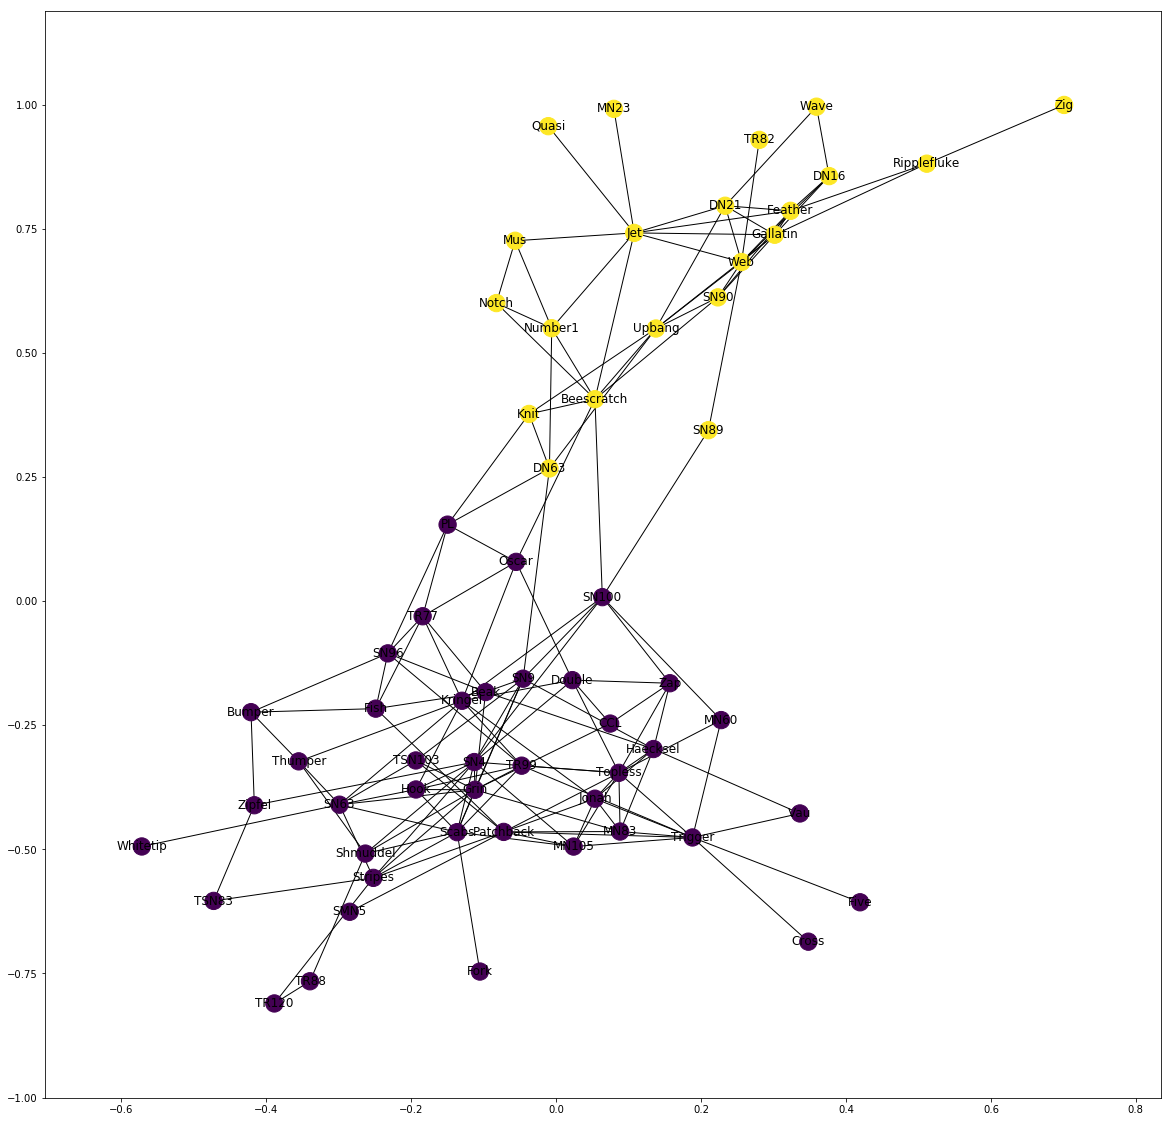

2


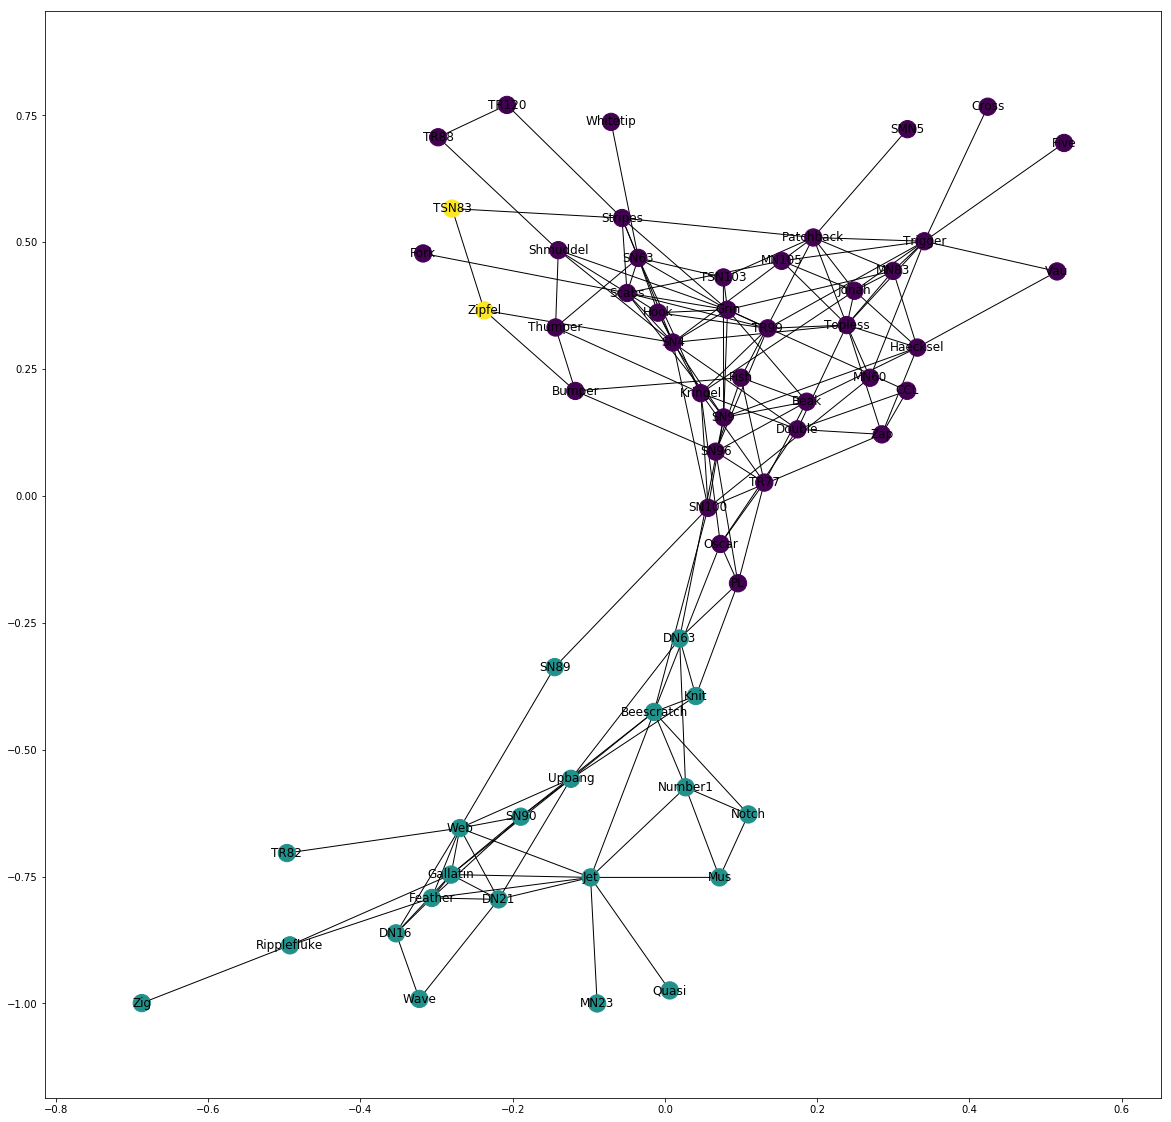

3


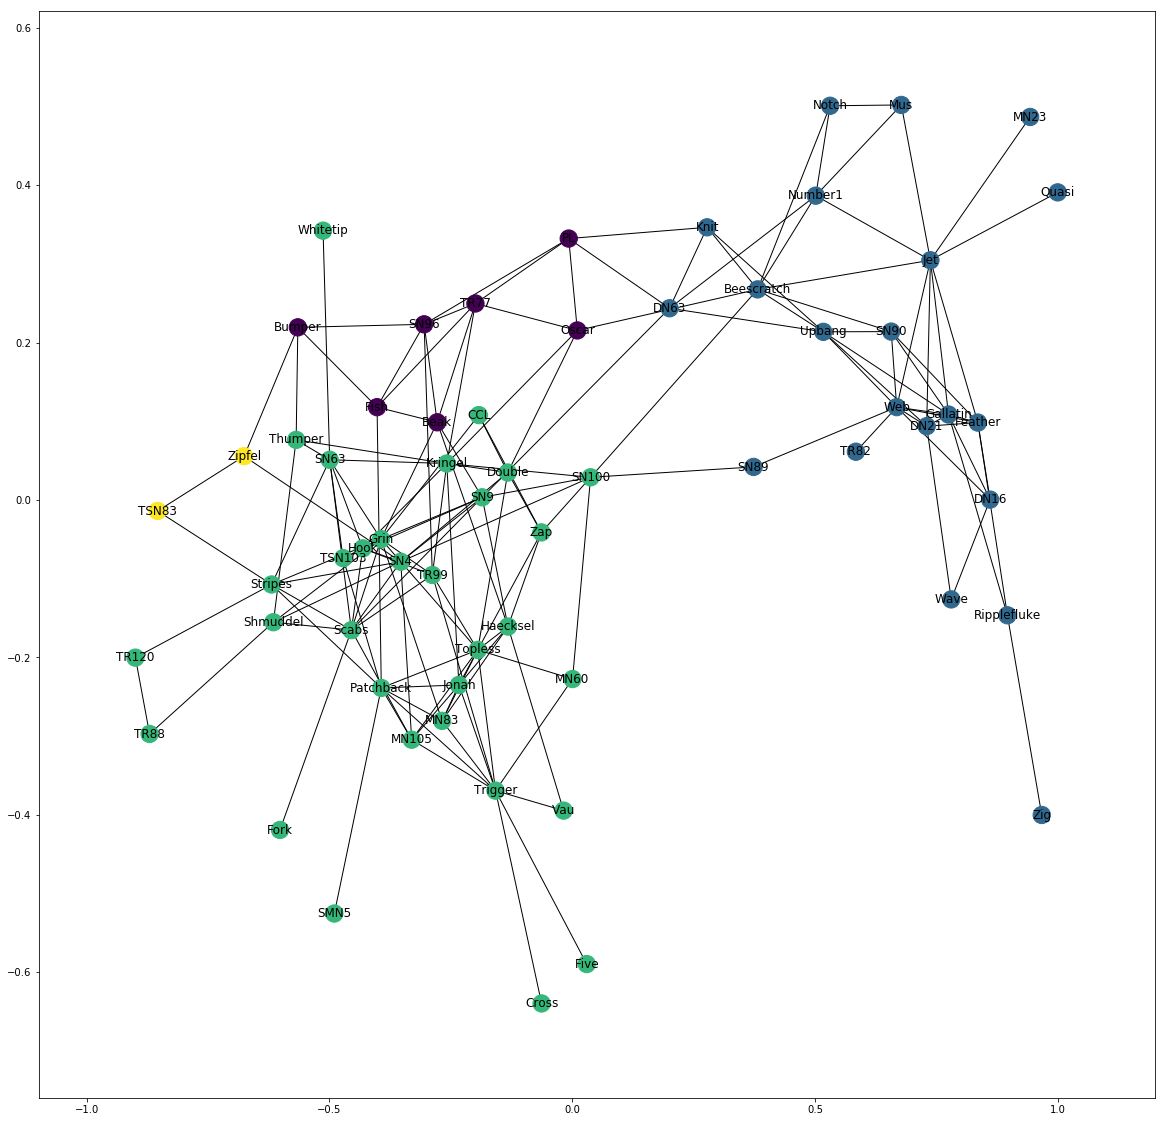

4


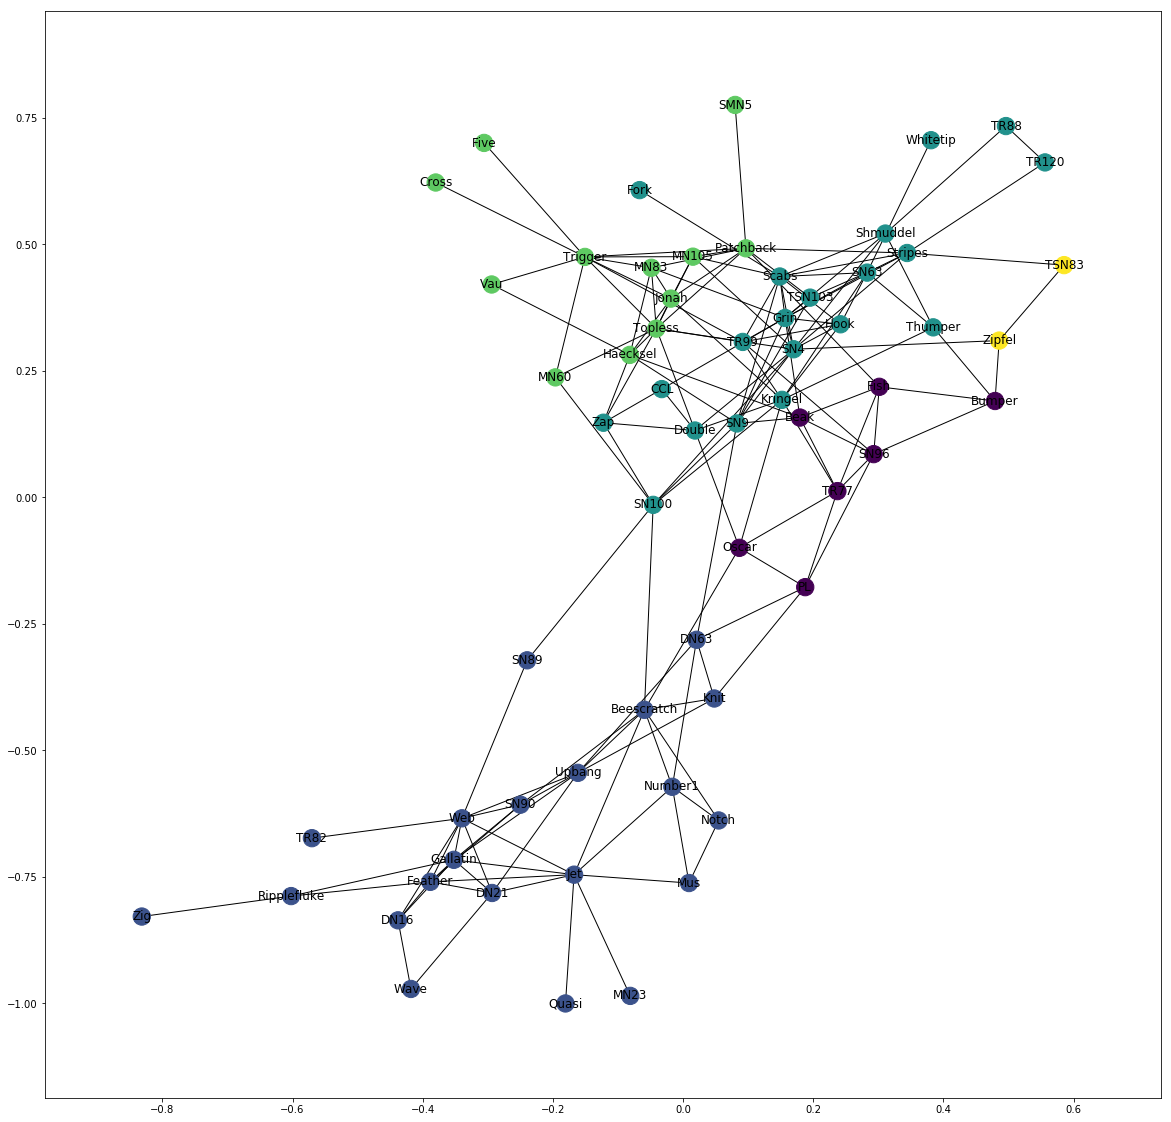

5


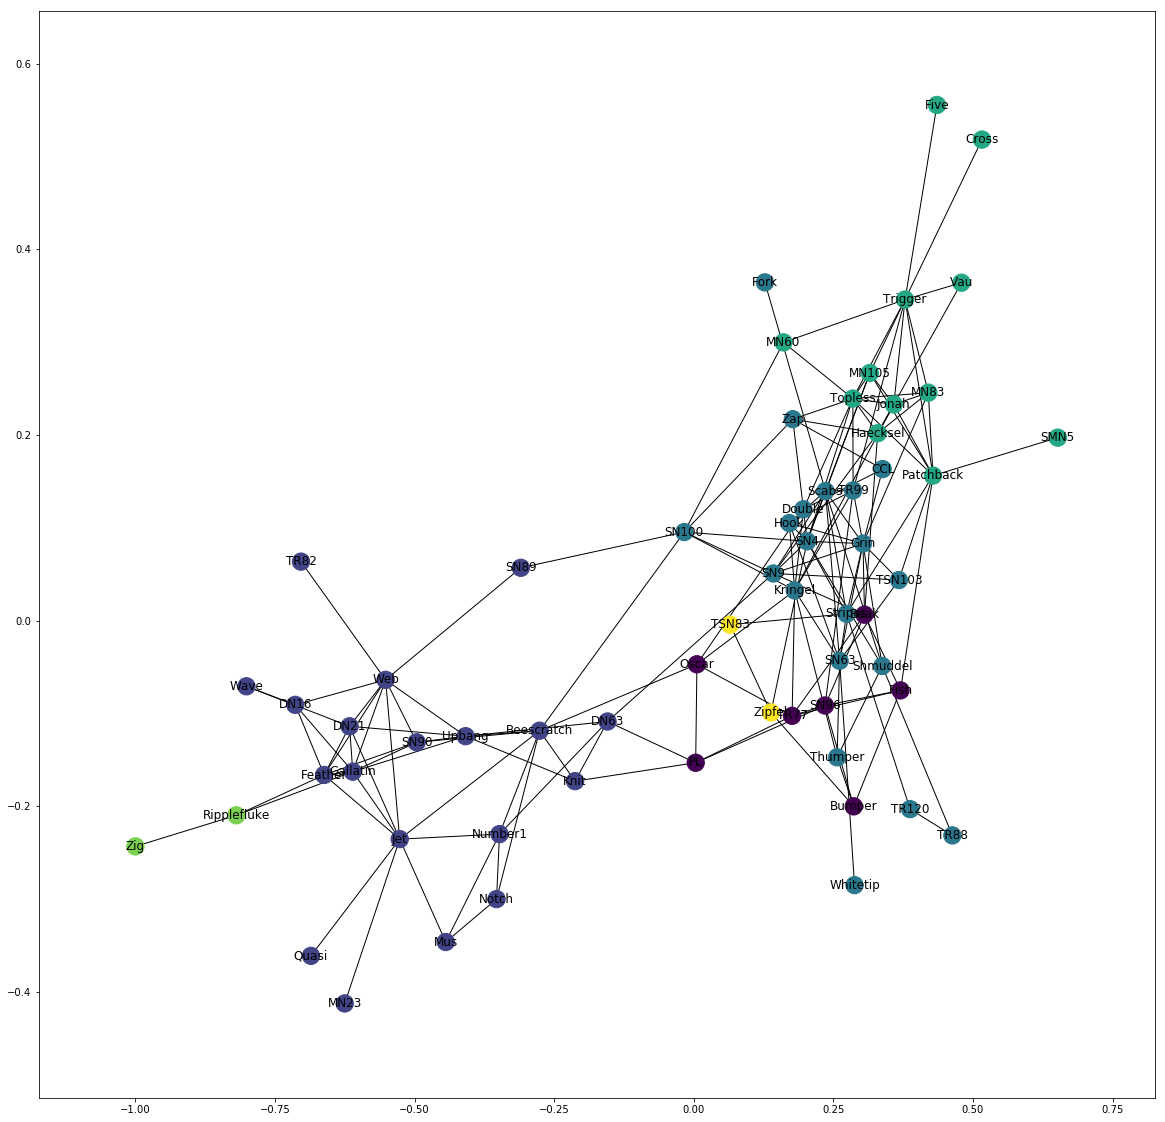

6


In [17]:
for comm  in list(girvan_newman(dolphins))[:5]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    n_clusts = len(comm)
    clusts = []
    for node in dolphins.nodes():
        found = False
        idx = 0
        while not found:
            if node in comm[idx]:
                found = True
            else:
                idx += 1
        clusts.append(idx)
    networkx.draw_networkx(dolphins, node_color=np.array([clusts])+1, ax=ax)
    plt.show()
    print(n_clusts)

`networkx` plotting methods helps with checking the communities since it's trying to distribute nodes in non-cluttered (planar-like) way. In first iterations we can see that this method chooses reasonable clusters as separate communities.

# community detection

I've chosen to test how PCA of adjacency matrix and k-means with cosine/euclidean distance behaves on community detecion task. Since we have ground truth labels we can evaluate performance taking that into account. Here we are are using "Adjusted Rand Index". It takes values from $\{-1, 1\}$, the higher the score, the better assignments, $0$ are totally random.

http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index

 The considered dataset is graph of communication via email in a large European research institution.
https://snap.stanford.edu/data/email-Eu-core.html

In [18]:
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cosine

In [19]:
emails = networkx.read_edgelist('./email-Eu-core.txt', create_using=networkx.Graph(), nodetype=int)
emails_labels = pd.read_csv('./email-Eu-core-department-labels.txt', sep=' ', header=None)[1].values

In [20]:
n_of_communities = len(np.unique(emails_labels))
adj_matrix = networkx.adj_matrix(emails).toarray()
components = np.linspace(n_of_communities, len(emails_labels), 5).astype(np.int)

In [25]:
scores_cosine = []
scores_euclidean = []
for comp in components:
    pca = PCA(n_components=comp)
    dec_adj_matrix = pca.fit_transform(adj_matrix)
    kmeans = KMeans(dec_adj_matrix, distance=cosine, n_of_clusters=42)
    kmeans.clusterize()
    scores_cosine.append(adjusted_rand_score(emails_labels, kmeans.clusters))
    kmeans = KMeans(dec_adj_matrix, n_of_clusters=42)
    kmeans.clusterize()
    scores_euclidean.append(adjusted_rand_score(emails_labels, kmeans.clusters))

In [26]:
kmeans = KMeans(adj_matrix, distance=cosine, n_of_clusters=42)
kmeans.clusterize()
print("KMeans, cosine, without PCA ", adjusted_rand_score(emails_labels, kmeans.clusters))
kmeans = KMeans(adj_matrix, n_of_clusters=42)
kmeans.clusterize()
print("KMeans, cosine, without PCA ", adjusted_rand_score(emails_labels, kmeans.clusters))

/home/unj/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


KMeans, cosine, without PCA  0.0
KMeans, cosine, without PCA  0.0719012486175


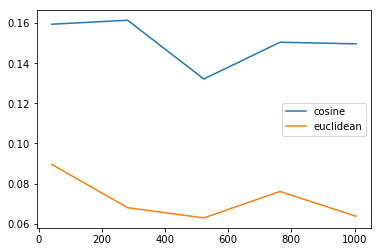

In [27]:
plt.plot(components, scores_cosine, label='cosine')
plt.plot(components, scores_euclidean, label='euclidean')
plt.legend()
plt.show()

As we can see on the plot cosine distance behaves much better in that context it maybe due to sparse nature of adjacency matrix. The interesting thing is that it has minimum between number of components equal 42 (number of true clusters) and 1005 (number of nodes). In the former one may think that we are not transforming out dataset at all, because it transforms it to another the same dimensionality. The fact is that it extracts information, because without PCA the score is equal $0$.

In [28]:
!ipython nbconvert lab2.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook lab2.ipynb to html
[NbConvertApp] Writing 5550286 bytes to lab2.html
